In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Set display options
np.set_printoptions(precision=3)
pd.options.display.precision = 3
%matplotlib inline

In [2]:
# Import dataset and checking data available

# Step 1: Upload the file
uploaded = files.upload()

# Step 2: Load the file into a pandas DataFrame
file_name = list(uploaded.keys())[0]  # Get the uploaded file name
print(f"Uploaded file: {file_name}")

# Load the file into a DataFrame
mpg = pd.read_excel(file_name)

# Step 3: Display the first few rows of the DataFrame
print("\nData Preview:")
print(mpg.head())

Saving mpg.data.xlsx to mpg.data.xlsx
Uploaded file: mpg.data.xlsx

Data Preview:
    mpg  cylinders  displayments  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model year  origin                   car name  Unnamed: 9  Unnamed: 10  \
0          70       1  chevrolet chevelle malibu         NaN          NaN   
1          70       1          buick skylark 320         NaN          NaN   
2          70       1         plymouth satellite         NaN          NaN   
3          70       1              amc rebel sst         NaN          NaN   
4          70       1                ford torino         NaN          NaN   

   Unnamed: 11 Unnamed: 12  
0    

In [3]:
# Preprocessing steps from D02

In [4]:
# Drop unnecessary columns

mpg = mpg.drop(columns = ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'])

In [5]:
# Correctly rename column "displayments"

mpg = mpg.rename(columns={'displayments': 'displacement'})

In [6]:
# Replace the two-digit year into a four-digit year, replace the model year column and drop the new column

mpg['model_year_full'] = mpg['model year'].apply(lambda x: 1900 + x if x >= 70 else 2000 + x)
mpg['model year'] = mpg['model_year_full']
mpg.drop('model_year_full', axis=1, inplace=True)

In [7]:
# Drop null values for the column 'mpg' and replace nulls in the 'horsepower' column with median

mpg = mpg.dropna(subset=["mpg"])
mpg['horsepower'] = mpg['horsepower'].fillna(mpg['horsepower'].median())

pd.isnull(mpg).sum()

<ipython-input-7-b6cd9bb2866f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpg['horsepower'] = mpg['horsepower'].fillna(mpg['horsepower'].median())


,0
mpg,0
cylinders,0
displacement,0
horsepower,0
weight,0
acceleration,0
model year,0
origin,0
car name,0


In [8]:
# Change data type for displacement and horsepower

columns_for_change = ['displacement', 'horsepower']
mpg[columns_for_change] = mpg[columns_for_change].astype(int)

In [9]:
# Split the "car model" column to make two separate columns "brand" and "car name"

mpg[['brand', 'model']] = mpg['car name'].str.split(' ', n=1, expand=True)
mpg['model'] = mpg['model'].str.replace(' ', ' ', regex=False)

In [10]:
# Remove "car name" and "model" columns

mpg.drop('car name', axis=1, inplace=True)
mpg.drop('model', axis=1, inplace=True)

In [11]:
# Correct the mispelled brand names

brand_corrections = {
    "vw": "volkswagen",
    "maxda": "mazda",
    "chevroelt": "chevrolet",
    "chevy": "chevrolet",
    "toyouta": "toyota",
    "mercedes": "mercedes-benz","vokswagen": "volkswagen","capri":"ford","mercury":"ford","triumph":"bmw","plymouth":"chrysler"}
mpg["brand"] = mpg["brand"].replace(brand_corrections)

In [12]:
# Determine the top brands (top 5 by count). One-hot encode the top brands and combine others

top_brands = mpg["brand"].value_counts().nlargest(5).index
mpg_encoded = pd.get_dummies(mpg["brand"].where(mpg["brand"].isin(top_brands), "other"))

In [13]:
# Merge "mpg" and "mpg_endoded" DataFrames and drop "brand" column

mpg = pd.concat([mpg, mpg_encoded], axis=1)
mpg.drop('brand', axis=1, inplace=True)

In [14]:
# New column Efficiency replacing numbers with categories
# (max - min) / 3 -> low (3), medium (2), high (1) fuel efficiency

# Calculate min, max, and range
min_mpg = mpg['mpg'].min()
max_mpg = mpg['mpg'].max()
range_mpg = max_mpg - min_mpg

# Calculate thresholds
thresholds = [min_mpg + range_mpg * i / 3 for i in (1, 2)]

# Define bins and labels
bins = [float('-inf')] + thresholds + [float('inf')]
labels = [3, 2, 1]  # Low (3), Medium (2), High (1)

# Apply classification
mpg['efficiency'] = pd.cut(mpg['mpg'], bins=bins, labels=labels, include_lowest=True)

In [15]:
# Remove "mpg" column

mpg.drop('mpg', axis=1, inplace=True)

mpg.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,amc,chevrolet,chrysler,dodge,ford,other,efficiency
0,8,307,130,3504,12.0,1970,1,False,True,False,False,False,False,3
1,8,350,165,3693,11.5,1970,1,False,False,False,False,False,True,3
2,8,318,150,3436,11.0,1970,1,False,False,True,False,False,False,3
3,8,304,150,3433,12.0,1970,1,True,False,False,False,False,False,3
4,8,302,140,3449,10.5,1970,1,False,False,False,False,True,False,3


In [16]:
# D03 Model - Evaluate - Predict - Fine Tune
# Decision Tree - Balanced

In [17]:
# Decision Tree Preparation

dec_tree_df = mpg.copy()

In [18]:
# Split the data into features (X) and target (y)
# features: cylinders, displacement, horsepower, weight, acceleration, model year, origin, brands, performance
# target: efficiency

X_dec_tree = dec_tree_df.drop(columns=['efficiency'])
y_dec_tree = dec_tree_df['efficiency']

In [ ]:
X_dec_tree.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,amc,chevrolet,chrysler,dodge,ford,other
0,8,307,130,3504,12.0,1970,1,False,True,False,False,False,False
1,8,350,165,3693,11.5,1970,1,False,False,False,False,False,True
2,8,318,150,3436,11.0,1970,1,False,False,True,False,False,False
3,8,304,150,3433,12.0,1970,1,True,False,False,False,False,False
4,8,302,140,3449,10.5,1970,1,False,False,False,False,True,False


In [ ]:
y_dec_tree.head()

,efficiency
0,3
1,3
2,3
3,3
4,3


In [19]:
# Feature

scaler = StandardScaler()
X_dec_tree_scaled = scaler.fit_transform(X_dec_tree)

In [20]:
# Split Data in train and test sets

X_dec_tree_train, X_dec_tree_test, y_dec_tree_train, y_dec_tree_test = train_test_split(X_dec_tree_scaled, y_dec_tree, test_size=0.2, random_state=42)

print(f'Training Set Size: {X_dec_tree_train.shape[0]} samples')
print(f'Test Set Size: {X_dec_tree_test.shape[0]} samples')

Training Set Size: 318 samples
Test Set Size: 80 samples


In [21]:
# Train the Decision Tree model

dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [22]:
# Fit the model on training data

dt_model.fit(X_dec_tree_train, y_dec_tree_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [23]:
# Predict on training data and test data

pred_train = dt_model.predict(X_dec_tree_train)
pred_test = dt_model.predict(X_dec_tree_test)

In [24]:
# Evaluate (Accuracy)

train_accuracy = accuracy_score(y_dec_tree_train, pred_train)
test_accuracy = accuracy_score(y_dec_tree_test, pred_test)

print(f"Decision Tree - Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Decision Tree - Test Accuracy: {test_accuracy * 100:.2f}%")

Decision Tree - Train Accuracy: 100.00%
Decision Tree - Test Accuracy: 78.75%


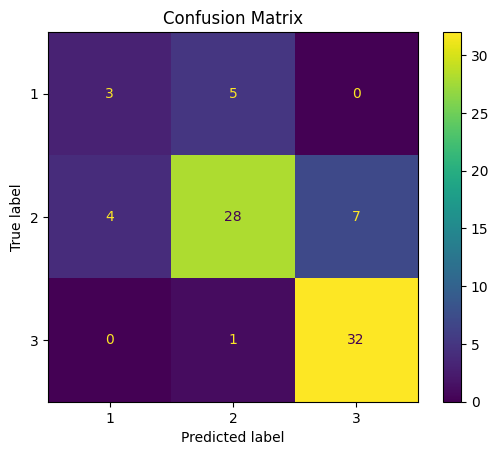

In [25]:
# Confusion Matrix

cm_display = ConfusionMatrixDisplay.from_estimator(dt_model, X_dec_tree_test, y_dec_tree_test, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [26]:
# Classification Report

print("Classification Report:")
print(classification_report(y_dec_tree_test, pred_test))

Classification Report:
              precision    recall  f1-score   support

           1       0.43      0.38      0.40         8
           2       0.82      0.72      0.77        39
           3       0.82      0.97      0.89        33

    accuracy                           0.79        80
   macro avg       0.69      0.69      0.69        80
weighted avg       0.78      0.79      0.78        80



In [ ]:
# Class 1 is poorly predicted with:
#Precision: 0.43, meaning 43% of predicted class 1 instances were correct.
#Recall: 0.38, indicating 38% of actual class 1 instances were correctly predicted.
#F1-Score: 0.40, balancing both precision and recall.
#Class 2 and 3 perform well with high precision, recall, and F1-scores. Overall, the model achieves good accuracy at 79%.

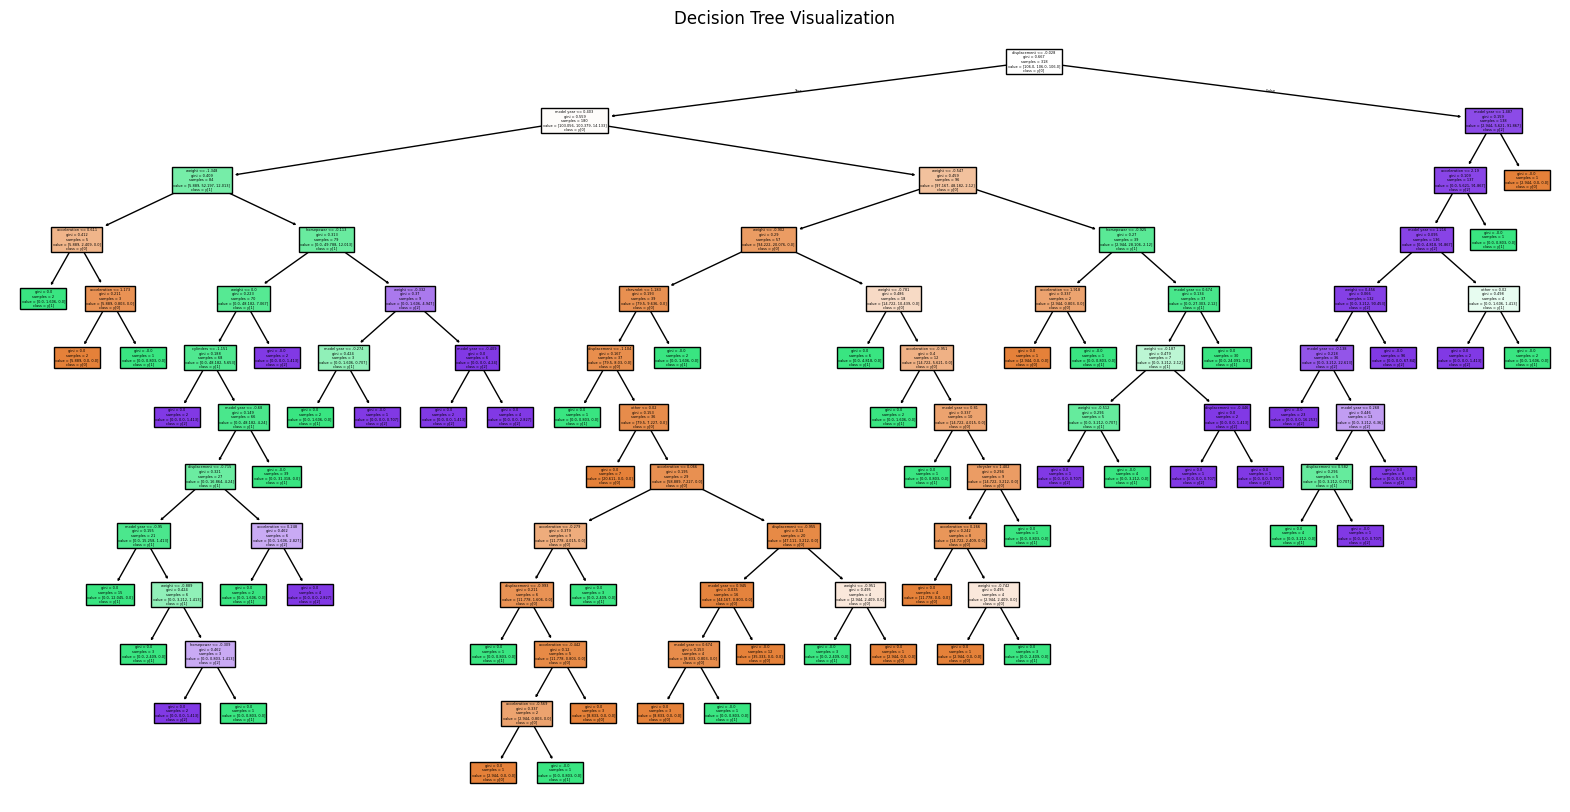

In [ ]:
# Visualisation of Decision Tree

plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=X_dec_tree.columns, class_names=True)
plt.title("Decision Tree Visualization")
plt.show()

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for DecisionTreeClassifier
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20],  # Depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],  # Minimum samples required to be at a leaf node
    'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split
    'max_features': [None, 'sqrt', 'log2']  # The number of features to consider for the best split
}

# Initialize the DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(X_dec_tree_train, y_dec_tree_train)

# Display the best hyperparameters
print("Best Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

# Use the best model from GridSearchCV
best_dt_model = grid_search.best_estimator_

# Predict using the optimized model
y_pred = best_dt_model.predict(X_dec_tree_test)

# Evaluate the model
print("Accuracy of Optimized Decision Tree Model:", accuracy_score(y_dec_tree_test, y_pred))
print("Classification Report:")
print(classification_report(y_dec_tree_test, y_pred))



Best Hyperparameters from GridSearchCV:
{'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy of Optimized Decision Tree Model: 0.7875
Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.38      0.46         8
           2       0.79      0.77      0.78        39
           3       0.81      0.91      0.86        33

    accuracy                           0.79        80
   macro avg       0.73      0.68      0.70        80
weighted avg       0.78      0.79      0.78        80

